In [2]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0
Tue Nov  7 23:47:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   28C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A 

In [3]:
import argparse
import json
import pickle
import string
import time

import numpy as np
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("--input-file", type=str, required=True)
parser.add_argument("--model", type=str, default="all-mpnet-base-v2")
# default="all-MiniLM-L12-v2")
# default="multi-qa-distilbert-cos-v1")
parser.add_argument("--batch-size", type=int, default=256)
parser.add_argument("--min-length", type=int)
parser.add_argument("--max-length", type=int)
parser.add_argument("--english-only", action="store_true")
parser.add_argument("--num-clusters", type=int, default=20)
parser.add_argument(
    "--cluster-alg",
    type=str,
    choices=["kmeans", "aggcls", "HDBSCAN"],
    default="kmeans",
)
parser.add_argument("--show-top-k", type=int, default=200)
parser.add_argument("--show-cut-off", type=int, default=512)


input_path = 'data/processed/sharegpt/sharegpt_data.jsonl'

cmd = f"""
    --input-file {input_path}
    --min-length 32
    --max-length 1536
"""

args = jpt_parse_args(parser, cmd)


num_clusters = args.num_clusters
show_top_k = args.show_top_k
show_cut_off = args.show_cut_off

args

Namespace(input_file='data/processed/sharegpt/sharegpt_data.jsonl', model='all-mpnet-base-v2', batch_size=256, min_length=32, max_length=1536, english_only=False, num_clusters=20, cluster_alg='kmeans', show_top_k=200, show_cut_off=512)

In [15]:
from fastchat_topic_clustering import read_texts, remove_punctuation

## wpq: modify read_text a bit
# texts = read_texts(
#     args.input_file, args.min_length, args.max_length, args.english_only
# )
input_file = args.input_file
min_length = args.min_length
max_length = args.max_length


visited = set()
texts = []

lines = json.load(open(input_file, "r"))
for l in lines:
    l = json.loads(l)['messages']
    line_texts = [x['content'] for x in l if x['role']=='user']
    for text in line_texts:
        text = text.strip()

        # Filter short or long prompts
        if min_length:
            if len(text) < min_length:
                continue
        if max_length:
            if len(text) > max_length:
                continue

        # De-duplication
        words = sorted([x.lower() for x in remove_punctuation(text).split(" ")])
        words = "".join(words)
        if words in visited:
            continue

        visited.add(words)
        texts.append(text)
        
print(f"#text: {len(texts)}")

In [17]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)

[2023-11-08 00:02:46,673] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Batches:   4%|▍         | 53/1202 [01:36<34:53,  1.82s/it]

KeyboardInterrupt



Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7f19c4a4e590>> (for post_execute):


KeyboardInterrupt: 

In [21]:
# max([len(x) for x in texts])


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/'+args.model)
tokenizer


MPNetTokenizerFast(name_or_path='sentence-transformers/all-mpnet-base-v2', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, norm

In [27]:
input_ids = tokenizer(texts[:10000]).input_ids
lens = [len(x) for x in input_ids]
lens

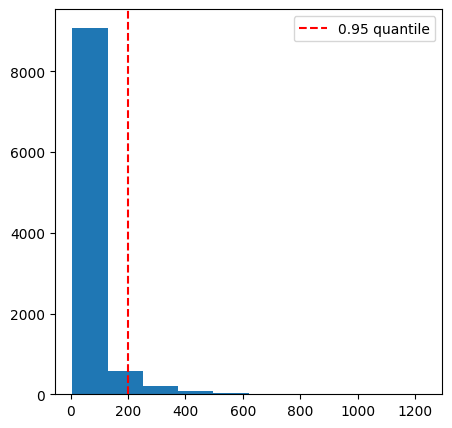

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.hist(lens)

q = .95
v = np.quantile(lens, q)
ax.axvline(x=v, color='r', linestyle='--', label=f'{q} quantile')
ax.legend()

In [16]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)
if args.cluster_alg == "kmeans":
    centers, labels = run_k_means(embeddings, num_clusters)
elif args.cluster_alg == "aggcls":
    centers, labels = run_agg_cluster(embeddings, num_clusters)
elif args.cluster_alg == "HDBSCAN":
    centers, labels = run_hdbscan_cluster(embeddings)
else:
    raise ValueError(f"Invalid clustering algorithm: {args.cluster_alg}")


307563